In [ ]:
import pandas as pd 

In [296]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot
import nltk
from nltk import PorterStemmer
porter = PorterStemmer()

from nltk.tokenize import word_tokenize

from nltk import punkt
from nltk.corpus import stopwords

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import pydot


In [233]:
sms = pd.read_csv("spam.csv", engine='python')

In [234]:
sms

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will �_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [235]:
sms = sms.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)

sms.columns = ['label','messages']
sms.head()

,label,messages
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


We want to add new features to our dataset, that could be predictive of a ham or a spam, such as length, spelling mistakes, abreviations ... 

Without preprocessig text 

First, we add features to our dataset

In [282]:
# length seems to be an indicator of a spam
sms['length'] = sms['messages'].apply(len)
sms.head()

,label,messages,length,capital,count
0,ham,"Go until jurong point, crazy.. Available only ...",111,3,0.009009
1,ham,Ok lar... Joking wif u oni...,29,2,0.034483
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,10,0.167742
3,ham,U dun say so early hor... U c already then say...,49,2,0.020408
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2,0.016393


In [283]:
#empirically, in a spam, one is more likely to see more capital letters. 
def capital_letter(message):
  return sum(1 for c in message if c.isupper())


In [238]:
sms['capital'] = sms['messages'].apply(capital_letter)
sms.head()

,label,messages,length,capital
0,ham,"Go until jurong point, crazy.. Available only ...",111,3
1,ham,Ok lar... Joking wif u oni...,29,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,10
3,ham,U dun say so early hor... U c already then say...,49,2
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


In [285]:
# Finally, one can expect to see more digit letters. 
# We create therefore an index of the relative number of digits in a message
def count(messages):
  numbers = sum(c.isdigit() for c in messages) + 1 
  letters = sum(c.isalpha() for c in messages)+1 
  spaces  = sum(c.isspace() for c in messages)
  others  = len(messages) - numbers - letters - spaces
  return numbers/(letters+numbers+spaces+others)

In [286]:
sms['relative_number_of_digits'] = sms['messages'].apply(count)
sms.head()

,label,messages,length,capital,count,relative_number_of_digits
0,ham,"Go until jurong point, crazy.. Available only ...",111,3,0.009009,0.009009
1,ham,Ok lar... Joking wif u oni...,29,2,0.034483,0.034483
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,10,0.167742,0.167742
3,ham,U dun say so early hor... U c already then say...,49,2,0.020408,0.020408
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2,0.016393,0.016393


Do we see differences between spam and ham, regarding these new features ? 

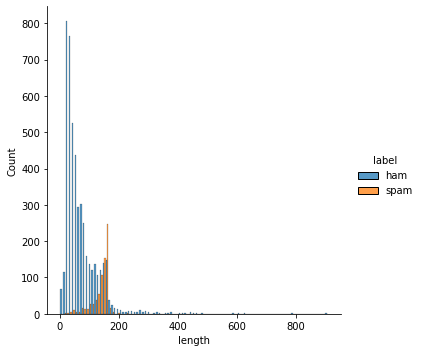

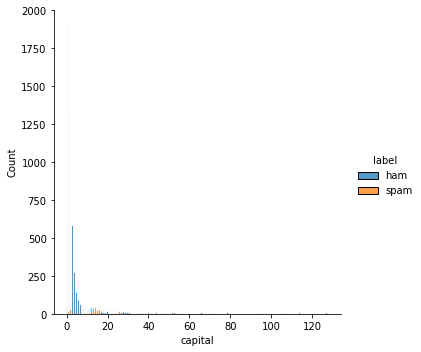

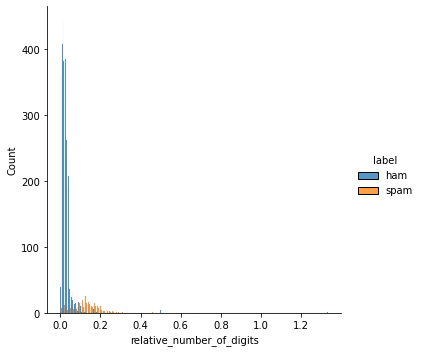

In [287]:
sns.displot(sms, x='length',hue='label', multiple = "dodge")
sns.displot(sms, x='capital',hue='label', multiple = "dodge")
sns.displot(sms, x='relative_number_of_digits',hue='label', multiple = "dodge")

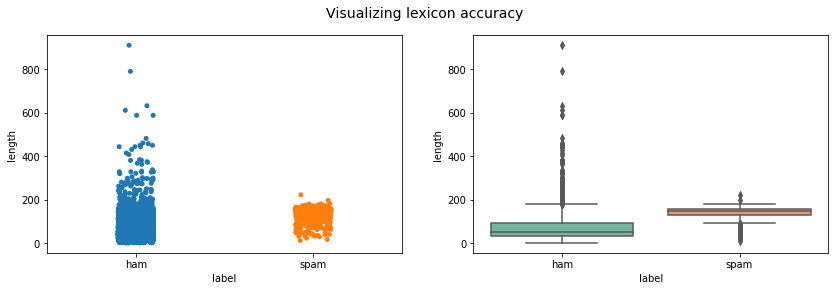

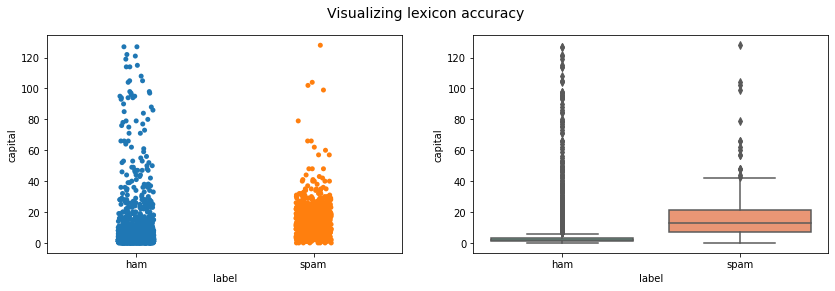

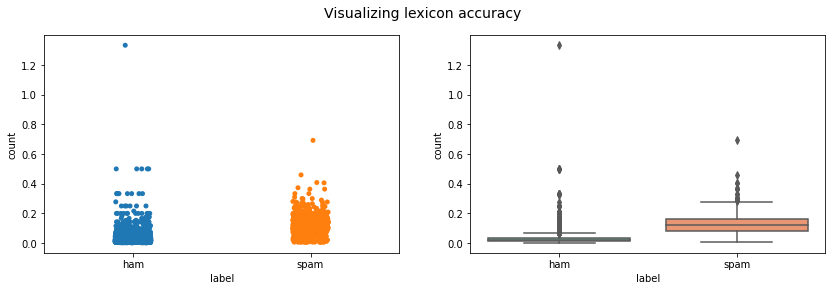

In [289]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sp = sns.stripplot(x='label', y="length", data=sms, ax=ax1)
bp = sns.boxplot(x='label', y="length", data=sms, palette="Set2", ax=ax2)
t = f.suptitle('Visualizing lexicon accuracy', fontsize=14)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sp = sns.stripplot(x='label', y="capital", data=sms, ax=ax1)
bp = sns.boxplot(x='label', y="capital", data=sms, palette="Set2", ax=ax2)
t = f.suptitle('Visualizing lexicon accuracy', fontsize=14)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sp = sns.stripplot(x='label', y="count", data=sms, ax=ax1)
bp = sns.boxplot(x='label', y="count", data=sms, palette="Set2", ax=ax2)
t = f.suptitle('Visualizing lexicon accuracy', fontsize=14)

There seem to be good distinctions between the two labels. We are now going to test different Machine Learnign Methods on these feature, particularly random forest and Neural Networks

In [290]:
# We first create dummy for the label 
label_dummies = pd.concat
([pd.get_dummies(sms['label'])['spam'], sms[['length','capital','count']]], axis=1)

In [247]:
label_dummies

,spam,length,capital,count
0,0,111,3,0.009009
1,0,29,2,0.034483
2,1,155,10,0.167742
3,0,49,2,0.020408
4,0,61,2,0.016393
...,...,...,...,...
5567,1,160,9,0.137500
5568,0,37,1,0.027027
5569,0,57,2,0.017544
5570,0,125,2,0.008000


In [291]:
labels = np.array(label_dummies['spam'])

features= label_dummies.drop('spam', axis = 1)
feature_list = list(features.columns)
features = np.array(features)


In [292]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [293]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)


Training Features Shape: (4179, 3)
Training Labels Shape: (4179,)
Testing Features Shape: (1393, 3)
Testing Labels Shape: (1393,)


In [261]:
#TRAIN
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

rf.fit(train_features, train_labels);

In [295]:
#TEST
predictions = rf.predict(test_features)

errors = abs(predictions - test_labels)

print('Mean Absolute Error:', round(np.mean(errors), 2))

mape = 100 * (errors / (test_labels+1))

accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')


Mean Absolute Error: 0.04
Accuracy: 97.29 %.


In [298]:
#VIZUALISATION OF THE TREE

rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3) 
# we restrict to 3 layer to make it easier to see 
rf_small.fit(train_features, train_labels)

tree_small = rf_small.estimators_[5]

export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

In [299]:
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: count                Importance: 0.69
Variable: length               Importance: 0.21
Variable: capital              Importance: 0.1


[None, None, None]

In [300]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)
important_indices = [feature_list.index('count'), feature_list.index('length')]

train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

rf_most_important.fit(train_important, train_labels)

predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)
print('Mean Absolute Error:', round(np.mean(errors), 2))
mape = np.mean(100 * (errors / (test_labels+1)))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')


Mean Absolute Error: 0.04
Accuracy: 97.02 %.


The capital feature is not very usefull...